Using data of [`Predicting Molecular Properties`](https://www.kaggle.com/c/champs-scalar-coupling/data) competition. We have information about atom couples in molecules and need to predict `scalar_couplinng_constant` between these atoms.


## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split

# Boosted model
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

# EXPLORATORY ANALYSIS

## Data Loading and Overview

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
structures = pd.read_csv('structures.csv')

In [3]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [4]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4659076,dsgdb9nsd_000004,2,0,2JHC
1,4659077,dsgdb9nsd_000004,2,1,1JHC
2,4659078,dsgdb9nsd_000004,2,3,3JHH
3,4659079,dsgdb9nsd_000004,3,0,1JHC
4,4659080,dsgdb9nsd_000004,3,1,2JHC


In [5]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [6]:
submission.head() #predict and add scalar coupling constant in

,id,scalar_coupling_constant
0,4659076,0
1,4659077,0
2,4659078,0
3,4659079,0
4,4659080,0


In [7]:
print(f"There are: \n{train.shape[0]} rows in train data.")
print(f"{test.shape[0]} rows in test data.")
print(f"{train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"{test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"{structures['atom'].nunique()} unique atoms: {structures['atom'].unique()}")
print(f"{train['type'].nunique()} unique types: {train['type'].unique()}")

# nuniques - NaN are not included in the count

There are: 
4659076 rows in train data.
2505190 rows in test data.
85012 distinct molecules in train data.
45777 distinct molecules in test data.
5 unique atoms: ['C' 'H' 'N' 'O' 'F']
8 unique types: ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


In main data files, the information about molecules and pairs of atoms:
   * test set ~ 50% of train set size (2 times smaller)
   * There are 5 different atoms and 8 coupling types

## Minimalize representation
* Recode atomic names to atomic numbers
* All data are default as `float64` and `int64`, change this high precision for higher prediction speed
* Change `molecule_name` into `molecule_index` of `int32`


In [8]:
# use atomic numbers to recode atomic names
atomic_numbers = {
    'C' : 6,
    'H' : 1,
    'N' : 7,
    'O' : 8,
    'F' : 9}

In [9]:
# Change data types
train_dtypes = {
    'molecule_name' : 'category',
    'atom_index_0'  : 'int8',
    'atom_index_1'  : 'int8',
    'type'          : 'category',
    'scalar_coupling_constant' : 'float32'
}

structures_dtypes = {
    'molecule_name': 'category',
    'atom_index'   : 'int8',
    'atom'         : 'category',
    'x' : 'float32',
    'y' : 'float32',
    'z' : 'float32'
}

In [10]:
# train
train = pd.read_csv('train.csv', index_col='id', dtype=train_dtypes)
train['molecule_index'] = train.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train = train[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]

# structures
structures = pd.read_csv('structures.csv', dtype=structures_dtypes)
structures['molecule_index'] = structures.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures = structures[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures['atom'] = structures['atom'].replace(atomic_numbers).astype('int8')

# Test
test = pd.read_csv('test.csv', index_col='id', dtype=train_dtypes)
test['molecule_index'] = test.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
test = test[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]

# Submission
submission = pd.read_csv('sample_submission.csv', index_col='id')

In [11]:
train.head()

,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404


In [12]:
structures.head()

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397


## Atom index 0 and Atom index 1 Counting distribution

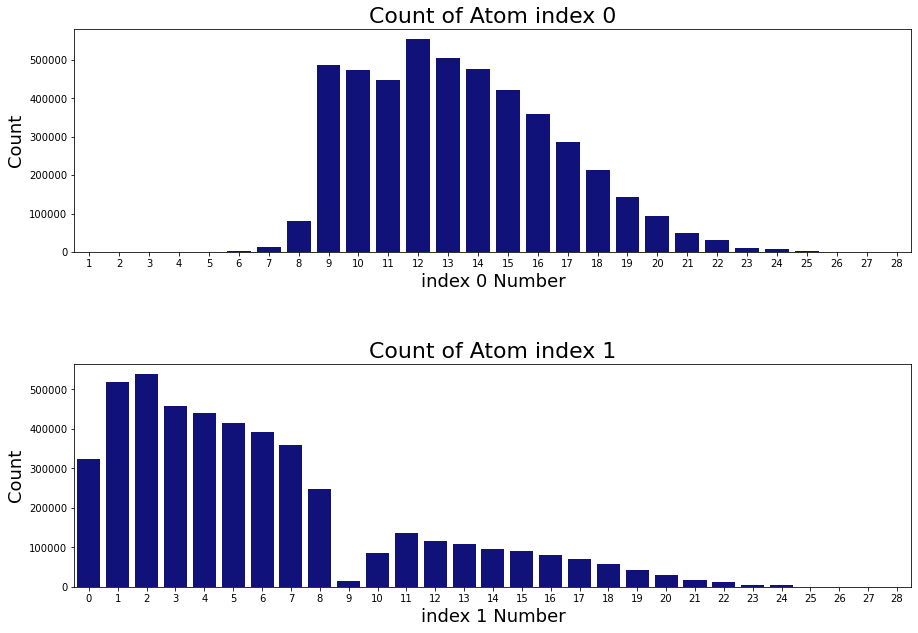

In [13]:
plt.figure(figsize=(15,10))

# Graph atom_index_0 distribution (atom_index_0 number vs Count)
plt.subplot(211) #2rows, 1column, index 1 (first subplot)
sns.countplot(x='atom_index_0', data=train, color='darkblue')
plt.title("Count of Atom index 0", fontsize=22)
plt.xlabel("index 0 Number", fontsize=18)
plt.ylabel("Count", fontsize=18)

# Graph atom_index_1 distribution (atom_index_1 number vs Count)
plt.subplot(212) # second subplot
sns.countplot(x='atom_index_1', data=train, color='darkblue')
plt.title("Count of Atom index 1", fontsize=22)
plt.xlabel("index 1 Number", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9)

## TARGET Scalar Coupling Constant Distribution and Different Types of Molecules
Understanding the target distribution and Different Molecule Types. <br>
There are **8 types** of molecule

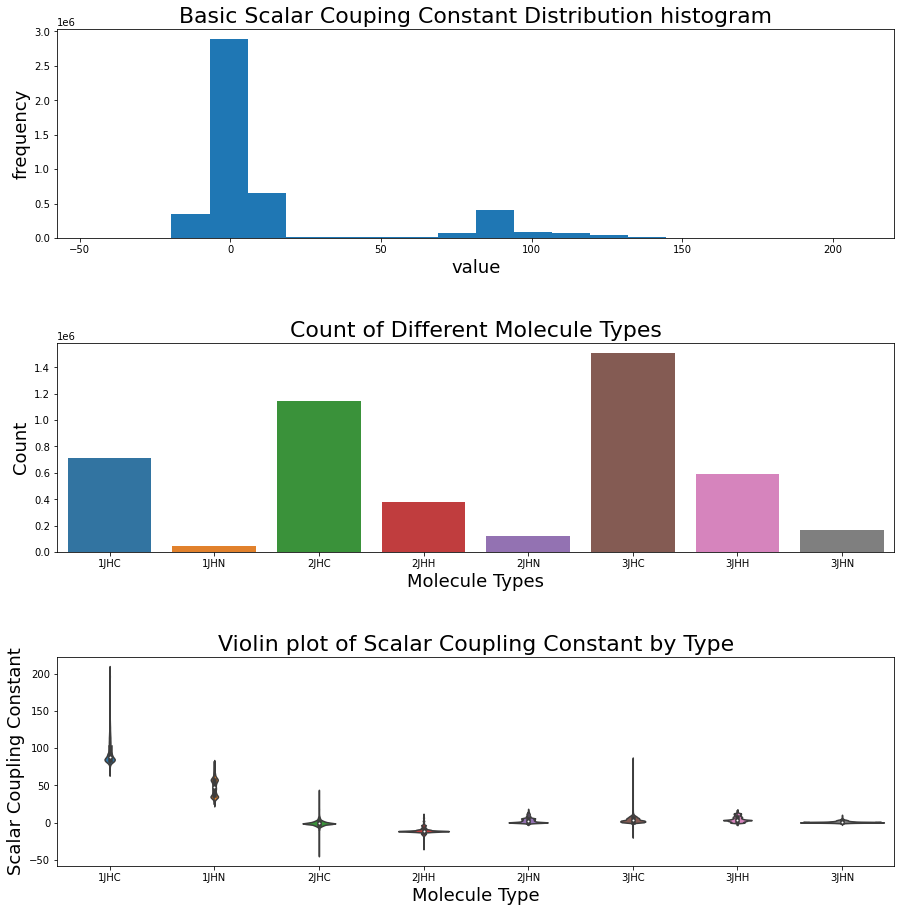

In [14]:
plt.figure(figsize=(15,15))

# Graph basic distribution of Scalar Coupling Constant
plt.subplot(311) 
plt.hist(train['scalar_coupling_constant'], bins=20)
plt.title('Basic Scalar Couping Constant Distribution histogram', fontsize = 22)
plt.xlabel('value', fontsize=18)
plt.ylabel('frequency', fontsize=18)

# Graph different type of molecule and their counts
plt.subplot(312)
sns.countplot(x='type', data=train)
plt.title("Count of Different Molecule Types", fontsize=22)
plt.xlabel('Molecule Types', fontsize=18)
plt.ylabel("Count", fontsize=18)

# Graph Violin distribution of Scalar Coupling Constant by Molecule Type
plt.subplot(313)
sns.violinplot(x='type', y='scalar_coupling_constant', data=train)
plt.title('Violin plot of Scalar Coupling Constant by Type', fontsize=22)
plt.xlabel('Molecule Type', fontsize=18)
plt.ylabel('Scalar Coupling Constant', fontsize=18)

plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9)

* **From the 2 atom distribution histograms:**
    - Among the first atoms of the molecule pairs, there are little counts of atoms with index lower than 7 or higher than 24
    - Among the second atoms of the molecule pairs, there are little number of atoms with index higher than 24. Also, atom with index 9 is quite rare

* **From basic coupling constant distribution histogram:**
    - Target variable (scalar coupling constant) has a bimodel distribution (there are 2 peak area)

* **From type distribution histogram:**
    - There are 3 types very popular (3JHC, 2JHC, 1JHC), 3 quite rare (1JHN, 2JHN, 3JHN), and 2 with medium frequency (2JHH, 3JHH)
    - *H-C are popular, H-H are average, H-N are rare*

* **From the violin plot of scalar coupling constant by types:**
    - The distribution by types of the target variable is very unevenly
    
    
Different coupling types have very different values of target variable (scalar coupling constant). Hence, should build separate models for each type

# Distance as main feature - SCHEME

If there are 2 atoms: we can represent uniquely the combo with 3 features:
- Distance `d_1_0` (0_1 is the same and 1_1, 0_0 is zeros)
- Types for `atom_0` and `atom_1`

3 atoms with 6 features:
- Distances `d_0_1`, `d_1_2`, `d_2_0`
- Types for `atom_0`, `atom_1`,`atom_2`

4 atoms with 10 features:
- distances: `d_1_0`, `d_1_2`, `d_1_3`, `d_2_0`, `d_2_3`, `d_3_0`
- and types for `atom_0`, `atom_1`, `atom_2`, `atom_3`

4 core atoms distances are enough to uniquely describe each next atom. So each next atom will have only 4 distances

**Hypothesis:**
- 2 similar sets of atoms with same distances between them and same types will have very close scalar coupling constant
- Neighbor atoms effect: closer distance atoms to the predicting pair have higher influence effect on scalar coupling constant


**System for each coupling atom pair:**

1. Take center point between first 2 core atoms
2. Calculate all distances to the rest of atoms in molecule
3. Find n-closest atoms and sort them by distance
4. Take 2 closest atoms from step (3) to create **4 core atoms**
5. Calculate distances from 4 core atoms to the rest of the atoms and to the core atoms as well.
6. Result in a list of tuples ordered by distance to center: `[(atom_type, distance_i_0, distance_i_1, distance_i_2, distance_i_3)]`



## Build Distance Dataset

In [15]:
# build a dataframe for each called type included: 
# [id, molecule_index, atom_index_0, atom_index_1, scalar coupling constant]

def build_type_df(base, struct, coupling_type):
    # find all rows with input coupling_type 
    # --> base = everything with input coupling_type
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index() # make new df for only 1 type
    base['id'] = base['id'].astype('int32') #originally int64 to int32
    
    # search for strucutres of those molecules of this type
    # then return the structures df for this 1 type only
    struct = struct[struct['molecule_index'].isin(base['molecule_index'])]
    return base, struct

In [16]:
# add coordinate for atom of called {index}
# this is to calculate distance from center --> def add_center 

# base, structures for only 1 input type (from the newly created df)
def add_coordinates(base, struct, index):
    # from base df: On the left read atom_index_{0} since index=0
    # On the right of the base df, add in the atom_index and the rest of coordinate
    df = pd.merge(base, struct, how='inner', 
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index'])
    
    # drop redundant column (after choosing according to index
    df = df.drop('atom_index', axis=1)
    
    # Since input index=0, the coordinator follow the index
    # change the name for clearer 
    df = df.rename(columns={'atom': f'atom_{index}',
                            'x' : f'x_{index}',
                            'y' : f'y_{index}',
                            'z' : f'z_{index}'})
    return df

In [17]:
# add the called atom pairs into base df
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df    

In [18]:
# creating atoms df
def merge_all_atoms(base, struct):
    df = pd.merge(base, struct, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    
    # Finding the atoms that are different from the core pair
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [19]:
# calculate the 4 distances
def add_center(df):
    df['x_c'] = (df['x_1'] + df['x_0']) * np.float32(0.5)
    df['y_c'] = (df['y_1'] + df['y_0']) * np.float32(0.5)
    df['z_c'] = (df['z_1'] + df['z_0']) * np.float32(0.5)
    
def add_dist_to_center(df):
    df['dist_c'] = ((df['x_c'] - df['x'])**np.float32(2) + 
                    (df['y_c'] - df['y'])**np.float32(2) + 
                    (df['z_c'] - df['z'])**np.float32(2)
                   )**np.float32(0.5)
    
def add_dist_between(df, i, vi):
    df[f'd_{i}_{vi}'] = (
        (df[f'x_{i}'] - df[f'x_{vi}'])**np.float32(2) + 
        (df[f'y_{i}'] - df[f'y_{vi}'])**np.float32(2) +
        (df[f'z_{i}'] - df[f'z_{vi}'])**np.float32(2)
    )**np.float32(0.5)
        
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_dist_between(df, i, vi)
            

In [20]:
def add_n_atoms(base, struct):
    dfs = struct['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)


In [21]:
def build_couple_df(data, structures, coupling_type, n_atoms =10):
    # build_type_df for input type
    base, structures = build_type_df(data, structures, coupling_type)
    
    # add coordinate for atom_index_0 and 1 
    base = add_coordinates(base, structures, 0) # -- atom 0, x_0, y_0, z_0
    base = add_coordinates(base, structures, 1) # -- atom 1, x_1, y_1, z_1
    
    # after adding coordinate, column atom_0 and atom_1 is useless
    # since it's for 1 tyoe, always same atom_0 and atom_1 thoughout df
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    # atoms = X data --> drop name and id (uneed data)
    atoms = base.drop('id', axis=1).copy()
    
    if 'scalar_coupling_constant' in data:
        # atoms = our X data, hide the target variable
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
    
    # Find center point for each pair
    # then remove each atom_index coordinates since only use to find center
    add_center(atoms) # --> x_c, y_c, z_c
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    
    # combine atoms df with all others
    atoms = merge_all_atoms(atoms, structures)
    
    # find distance from center of all others to core atoms
    # then drop the center value after used
    add_dist_to_center(atoms) # --> dist_c
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    
    # sort these neighbor atoms distance from closest to furthest
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'dist_c'], inplace=True)
    
    # group by each molecule, 
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    
    # then drop dist_c after used 
    atoms = atoms.drop(['dist_c'], axis=1)
    
    atoms = atoms[atoms['num'] < n_atoms]
    
    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int 8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
    
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    # combine with the base feature
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [22]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)
        
    # calculate distance for atom 0_1, 0_2,...
    # not for 1_1, 2_2, 3_3 because equal to zeros
    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
        
    return df[labels]

# Check with rarest type 1JHN

In [23]:
%%time
full = build_couple_df(train, structures, '1JHN', n_atoms=10)
print(full.shape)

(43680, 73)
Wall time: 1.73 s


In [24]:
full.columns

Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2',
       'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4',
       'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1',
       'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1',
       'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1',
       'd_9_2', 'd_9_3'],
      dtype='object')

In [25]:
df = take_n_atoms(full, 7)
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')

In [26]:
X = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y = df['scalar_coupling_constant'].values.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34944, 23), (8736, 23), (34944,), (8736,))

In [27]:
# Configuration params for LightGBM
lgb_params = {
    'num_leaves': 128,
    'min_child_samples': 79,
    'objective': 'regression',
    'max_depth': 9,
    'learning_rate': 0.2,
    'boosting_type': 'gbdt',
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'metric': 'mae',
    'verbosity': -1,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0}

In [28]:
model = LGBMRegressor(**lgb_params, n_estimators=1500, n_jobs = -1)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          eval_metric='mae',
          verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_test)
np.log(mean_absolute_error(y_test, y_pred))

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.425726	valid_1's l1: 0.519051
[200]	training's l1: 0.342327	valid_1's l1: 0.467659
[300]	training's l1: 0.298076	valid_1's l1: 0.445475
[400]	training's l1: 0.266349	valid_1's l1: 0.430548
[500]	training's l1: 0.240789	valid_1's l1: 0.420114
[600]	training's l1: 0.219443	valid_1's l1: 0.411668
[700]	training's l1: 0.201785	valid_1's l1: 0.406416
[800]	training's l1: 0.18589	valid_1's l1: 0.401332
[900]	training's l1: 0.173295	valid_1's l1: 0.39753
[1000]	training's l1: 0.162172	valid_1's l1: 0.394476
[1100]	training's l1: 0.152021	valid_1's l1: 0.391592
[1200]	training's l1: 0.142223	valid_1's l1: 0.388927
[1300]	training's l1: 0.133892	valid_1's l1: 0.386931
[1400]	training's l1: 0.125548	valid_1's l1: 0.385524
[1500]	training's l1: 0.118248	valid_1's l1: 0.38368
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.118248	valid_1's l1: 0.38368


-0.9579452127063544

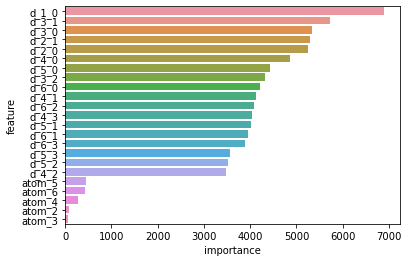

In [29]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 
                              'importance': model.feature_importances_})

sns.barplot(x="importance", y="feature", 
            data=df_importance.sort_values('importance', ascending=False));


The atom types is less importance than the distance interaction between neighbor atoms.

# Model Regression

In [34]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X = df.values.astype('float32')
        y = None
    
    return X, y

In [31]:
def train_and_predict_by_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=18):
    print(f'************ Training model for type {coupling_type} ************')
    
    # nparray
    X, y        = build_X_y_data(train, coupling_type, n_atoms)
    X_test, _   = build_X_y_data(test, coupling_type, n_atoms)
    predictions = np.zeros(X_test.shape[0], dtype='float32')
    
    cv_score = 0
    
    if n_folds > n_splits: n_splits = n_folds
    
    kfolds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for fold, (train_index, valid_index) in enumerate(kfolds.split(X, y)):
        if fold >= n_folds: break
        
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
            
        model = LGBMRegressor(**lgb_params, n_estimators = 1500, n_jobs = -1)
        model.fit(X_train, y_train, 
                  eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                  eval_metric='mae',
                  verbose=100, early_stopping_rounds=200)
        
        y_pred_valid = model.predict(X_valid)
        val_score = np.log(mean_absolute_error(y_valid, y_pred_valid))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        

        cv_score += val_score / n_folds
        predictions += model.predict(X_test) / n_folds
        
       

    submission.loc[test['type'] == coupling_type, 'scalar_coupling_constant'] = predictions
    return cv_score

In [35]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}

folds = 3
submit = submission.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_by_type(
        coupling_type, 
        submit, 
        n_atoms=model_params[coupling_type],
        n_folds=folds)
    
    cv_scores[coupling_type] = cv_score
                                        

************ Training model for type 1JHN ************
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.425071	valid_1's l1: 0.520073
[200]	training's l1: 0.339643	valid_1's l1: 0.464891
[300]	training's l1: 0.292997	valid_1's l1: 0.441549
[400]	training's l1: 0.261397	valid_1's l1: 0.427557
[500]	training's l1: 0.238089	valid_1's l1: 0.41846
[600]	training's l1: 0.217456	valid_1's l1: 0.410372
[700]	training's l1

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.255628	valid_1's l1: 0.280362
[200]	training's l1: 0.208493	valid_1's l1: 0.24462
[300]	training's l1: 0.184133	valid_1's l1: 0.227757
[400]	training's l1: 0.167304	valid_1's l1: 0.218122
[500]	training's l1: 0.154124	valid_1's l1: 0.21081
[600]	training's l1: 0.143476	valid_1's l1: 0.205225
[700]	training's l1: 0.13466	valid_1's l1: 0.200841
[800]	training's l1: 0.126882	valid_1's l1: 0.197187
[900]	training's l1: 0.120293	valid_1's l1: 0.194291
[1000]	training's l1: 0.114263	valid_1's l1: 0.191697
[1100]	training's l1: 0.108762	valid_1's l1: 0.189338
[1200]	training's l1: 0.103744	valid_1's l1: 0.187391
[1300]	training's l1: 0.0992824	valid_1's l1: 0.185611
[1400]	training's l1: 0.0952858	valid_1's l1: 0.184083
[1500]	training's l1: 0.0913713	valid_1's l1: 0.182547
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0913713	valid_1's l1: 0.182547
2JHH Fold 0, logMAE: -1.7007484348

[1000]	training's l1: 0.270609	valid_1's l1: 0.330573
[1100]	training's l1: 0.262216	valid_1's l1: 0.32538
[1200]	training's l1: 0.254403	valid_1's l1: 0.320655
[1300]	training's l1: 0.247138	valid_1's l1: 0.31608
[1400]	training's l1: 0.24059	valid_1's l1: 0.312343
[1500]	training's l1: 0.234495	valid_1's l1: 0.308888
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.234495	valid_1's l1: 0.308888
2JHC Fold 0, logMAE: -1.1747771994147171
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.497603	valid_1's l1: 0.512783
[200]	training's l1: 0.422419	valid_1's l1: 0.445992
[300]	training's l1: 0.381885	valid_1's l1: 0.411745
[400]	training's l1: 0.353203	valid_1's l1: 0.388821
[500]	training's l1: 0.332176	valid_1's l1: 0.373084
[600]	training's l1: 0.315439	valid_1's l1: 0.360851
[700]	training's l1: 0.301248	valid_1's l1: 0.350759
[800]	training's l1: 0.289192	valid_1's l1: 0.342571
[900]	training's l1: 0.278537	valid_1's l1: 0.3355

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.554266	valid_1's l1: 0.566864
[200]	training's l1: 0.4726	valid_1's l1: 0.492096
[300]	training's l1: 0.428376	valid_1's l1: 0.453545
[400]	training's l1: 0.399934	valid_1's l1: 0.430079
[500]	training's l1: 0.378348	valid_1's l1: 0.413107
[600]	training's l1: 0.360462	valid_1's l1: 0.399366
[700]	training's l1: 0.34552	valid_1's l1: 0.388255
[800]	training's l1: 0.332834	valid_1's l1: 0.379022
[900]	training's l1: 0.321772	valid_1's l1: 0.371193
[1000]	training's l1: 0.311709	valid_1's l1: 0.364261
[1100]	training's l1: 0.302915	valid_1's l1: 0.358553
[1200]	training's l1: 0.294713	valid_1's l1: 0.353328
[1300]	training's l1: 0.287347	valid_1's l1: 0.348722
[1400]	training's l1: 0.28033	valid_1's l1: 0.344303
[1500]	training's l1: 0.274042	valid_1's l1: 0.34065
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.274042	valid_1's l1: 0.34065
3JHC Fold 1, logMAE: -1.0769003261642613


# Checking performance
check CV scores for each types:

In [36]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

,type,cv_score
0,1JHN,-0.960808
1,1JHC,-0.249884
2,2JHH,-1.711006
3,2JHN,-1.912688
4,2JHC,-1.175575
5,3JHH,-1.736120
6,3JHC,-1.077396
7,3JHN,-2.166069


In [37]:
# CV mean score
np.mean(list(cv_scores.values()))

-1.3736931541358173

In [41]:
submit.head(10)

,scalar_coupling_constant
id,
4659076,21.667225
4659077,191.454086
4659078,6.092198
4659079,191.454086
4659080,21.667225
4659081,86.363472
4659082,-3.943934
4659083,-10.830262
4659084,-11.440856
